In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from pytorch_ranger import Ranger
from sklearn.model_selection import KFold
import torchvision.models as models

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Functions for modifying data

In [2]:
#function for making the number of frames equal to a certain number by filling zeroes given the df of a single file

def fillframes(frame_num, file_id, df):
    max_frame = df['frame'].max()
    cont_list = set(range(max_frame+1))
    missing_frames = sorted(list(cont_list - set(df['frame'])))
    
    for i in missing_frames:
        if i == 0:
            newdf = pd.DataFrame([{'frame':0, 'DetObj#':0, 'x':0, 'y':0, 'z':0, 'v':0, 'source_file_id':file_id}])
            df = pd.concat([newdf, df], ignore_index=True).reset_index(drop=True)
        else:
            index_tochange = df[df['frame'] == i-1].index[-1]
            newdf = pd.DataFrame([{'frame':i, 'DetObj#':0, 'x':0, 'y':0, 'z':0, 'v':0, 'source_file_id':file_id}])
            df = pd.concat([df.iloc[:index_tochange+1], newdf, df.iloc[index_tochange+1:]]).reset_index(drop=True)
    
    if max_frame != frame_num:
        index_tochange = df.index[-1]
        for i in range(max_frame+1, frame_num+1):
            newdf = pd.DataFrame([{'frame':i, 'DetObj#':0, 'x':0, 'y':0, 'z':0, 'v':0, 'source_file_id':file_id}])
            df = pd.concat([df.iloc[:index_tochange+1], newdf, df.iloc[index_tochange+1:]]).reset_index(drop=True)
            index_tochange += 1
    
            
    return df

In [3]:
#function for making the number of points equal to a certain number in all frames of a file
def fillpoints(maxpoints, file_id, df):

    for i in range(df['frame'].max()+1): #looping through frames
        df_thisframe = df[df['frame']==i]
        if df_thisframe['DetObj#'].max() < maxpoints:
            thisframe_maxpoints = df_thisframe['DetObj#'].max()
            index_tochange = df_thisframe.index[-1]
            
            newdf = pd.DataFrame(np.zeros((maxpoints - thisframe_maxpoints, 4)), columns=['x', 'y', 'z', 'v'])
            newdf['frame'] = i
            newdf['DetObj#'] = range(thisframe_maxpoints+1, maxpoints+1)
            newdf['source_file_id'] = file_id
            
            df = pd.concat([df.iloc[:index_tochange+1], newdf, df.iloc[index_tochange+1:]]).reset_index(drop=True)
            
    return df

# Loading and modifying data

In [5]:
fall_newfiles = glob.glob('GatheredData/Fall/*.csv')
not_newfiles = glob.glob('GatheredData/Not/*.csv')
fall_newdf = pd.DataFrame()
not_newdf = pd.DataFrame()

In [6]:
#Making the Dataframe for the fall files

countFile = 0

for file in fall_newfiles:
    
    temp_df = pd.read_csv(file)
    temp_df['source_file_id'] = countFile
    countFile += 1
    
    fall_newdf = pd.concat([fall_newdf, temp_df], ignore_index=True)

In [7]:
#Making the Dataframe for the not files

for file in not_newfiles:
    
    temp_df = pd.read_csv(file)
    temp_df['source_file_id'] = countFile
    countFile += 1
    
    not_newdf = pd.concat([not_newdf, temp_df], ignore_index=True)

In [8]:
#Making a Dataframe that contains both, fall and not files
combined_newdf = pd.concat([fall_newdf, not_newdf], ignore_index=True)
combined_newdf.fillna(0, inplace=True)
combined_newdf

,frame,DetObj#,x,y,z,v,snr,noise,source_file_id
0,0,0,-0.106953,0.039879,-0.008597,0.0000,301,477,0
1,0,1,-0.432412,1.728784,-0.201075,0.0000,179,548,0
2,0,2,-0.115003,1.902050,-0.093566,0.0000,126,600,0
3,0,3,-0.569265,2.014436,-0.148715,0.0000,136,663,0
4,0,4,0.667018,2.087541,-0.308129,0.0000,116,641,0
...,...,...,...,...,...,...,...,...,...
22691,23,6,-0.741770,1.407398,0.401232,0.0796,163,437,101
22692,23,7,0.339259,1.663455,-1.478461,0.0796,117,444,101
22693,23,8,-0.746370,1.736218,1.223316,0.0796,117,444,101
22694,23,9,-0.414011,0.764946,-0.286456,0.1194,256,398,101


In [9]:
#Adding frames to files to make them all equal
max_frames = combined_newdf.groupby('source_file_id').agg({'frame':'max'})['frame'].max()
modded_newdf = pd.DataFrame()
for i in range(combined_newdf['source_file_id'].max()+1): #looping through all files
    temp_df = fillframes(max_frames, i, combined_newdf[combined_newdf['source_file_id']==i])
    modded_newdf = pd.concat([modded_newdf, temp_df], ignore_index=True)
    if (i%10==0): print('File No. ' +str(i)+ ' done!')
modded_newdf.fillna(0, inplace=True)
modded_newdf

File No. 0 done!
File No. 10 done!
File No. 20 done!
File No. 30 done!
File No. 40 done!
File No. 50 done!
File No. 60 done!
File No. 70 done!
File No. 80 done!
File No. 90 done!
File No. 100 done!


,frame,DetObj#,x,y,z,v,snr,noise,source_file_id
0,0,0,-0.106953,0.039879,-0.008597,0.0000,301.0,477.0,0
1,0,1,-0.432412,1.728784,-0.201075,0.0000,179.0,548.0,0
2,0,2,-0.115003,1.902050,-0.093566,0.0000,126.0,600.0,0
3,0,3,-0.569265,2.014436,-0.148715,0.0000,136.0,663.0,0
4,0,4,0.667018,2.087541,-0.308129,0.0000,116.0,641.0,0
...,...,...,...,...,...,...,...,...,...
22783,23,7,0.339259,1.663455,-1.478461,0.0796,117.0,444.0,101
22784,23,8,-0.746370,1.736218,1.223316,0.0796,117.0,444.0,101
22785,23,9,-0.414011,0.764946,-0.286456,0.1194,256.0,398.0,101
22786,23,10,-0.434712,0.672538,0.027841,0.2587,410.0,331.0,101


In [10]:
#checking if all files have same number of frames
modded_newdf = modded_newdf.sort_values(by=['source_file_id', 'frame', 'DetObj#']).reset_index(drop=True)
modded_newdf.groupby('source_file_id').agg({'frame':'max'}).values.min()

24

In [11]:
#Adding points to files to make them all equal
max_detobj = modded_newdf.groupby(['source_file_id','frame']).agg({'DetObj#':'max'}).values.max()
equal_newdf = pd.DataFrame()
for i in range(modded_newdf['source_file_id'].max()+1): #Looping through all files
    temp_df = fillpoints(max_detobj, i, modded_newdf[modded_newdf['source_file_id']==i])
    equal_newdf = pd.concat([equal_newdf, temp_df], ignore_index=True)
    if (i%10) == 0: print('File No. ' + str(i) + ' is done!')
equal_newdf.fillna(0, inplace=True)
equal_newdf

File No. 0 is done!
File No. 10 is done!
File No. 20 is done!
File No. 30 is done!
File No. 40 is done!
File No. 50 is done!
File No. 60 is done!
File No. 70 is done!
File No. 80 is done!
File No. 90 is done!
File No. 100 is done!


,frame,DetObj#,x,y,z,v,snr,noise,source_file_id
0,0,0,-0.106953,0.039879,-0.008597,0.0,301.0,477.0,0
1,0,1,-0.432412,1.728784,-0.201075,0.0,179.0,548.0,0
2,0,2,-0.115003,1.902050,-0.093566,0.0,126.0,600.0,0
3,0,3,-0.569265,2.014436,-0.148715,0.0,136.0,663.0,0
4,0,4,0.667018,2.087541,-0.308129,0.0,116.0,641.0,0
...,...,...,...,...,...,...,...,...,...
56095,0,17,0.000000,0.000000,0.000000,0.0,0.0,0.0,101
56096,0,18,0.000000,0.000000,0.000000,0.0,0.0,0.0,101
56097,0,19,0.000000,0.000000,0.000000,0.0,0.0,0.0,101
56098,0,20,0.000000,0.000000,0.000000,0.0,0.0,0.0,101


In [12]:
#checking if all frames of all files haves same number of points
equal_newdf = equal_newdf.sort_values(by=['source_file_id', 'frame', 'DetObj#']).reset_index(drop=True)
equal_newdf.groupby(['source_file_id','frame']).agg({'DetObj#':'max'}).values.min()

21

In [13]:
equal_newdf

,frame,DetObj#,x,y,z,v,snr,noise,source_file_id
0,0,0,-0.106953,0.039879,-0.008597,0.0,301.0,477.0,0
1,0,1,-0.432412,1.728784,-0.201075,0.0,179.0,548.0,0
2,0,2,-0.115003,1.902050,-0.093566,0.0,126.0,600.0,0
3,0,3,-0.569265,2.014436,-0.148715,0.0,136.0,663.0,0
4,0,4,0.667018,2.087541,-0.308129,0.0,116.0,641.0,0
...,...,...,...,...,...,...,...,...,...
56095,24,17,0.000000,0.000000,0.000000,0.0,0.0,0.0,101
56096,24,18,0.000000,0.000000,0.000000,0.0,0.0,0.0,101
56097,24,19,0.000000,0.000000,0.000000,0.0,0.0,0.0,101
56098,24,20,0.000000,0.000000,0.000000,0.0,0.0,0.0,101


In [16]:
#reshaping the matrix containing features
feats_new = equal_newdf[['x','y','z','v']].values
feat_newmatrix = feats_new.reshape(102, 25, 22, 4)
 
feat_newmatrix.shape

(102, 25, 22, 4)

In [17]:
#Making array for labels
labels_newarr = np.concatenate((np.ones(102 // 2), np.zeros(102 // 2)))

torch.tensor(labels_newarr).shape

torch.Size([102])

# CNN Model Architecture

In [43]:
import torch.nn.functional as F

# Define the CNN model
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(25, 16, kernel_size=5, stride=2, padding=2, dtype=torch.double) #first argument has to be 25 since there are 25 frames in a file
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, dtype=torch.double)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 5 * 1, 64, dtype=torch.double)
        self.fc2 = nn.Linear(64, 32, dtype=torch.double)
        self.fc3 = nn.Linear(32, 1, dtype=torch.double) 

        
    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.fc2(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.fc3(x)
        return x

# Training and Testing the model

In [44]:
#splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(torch.tensor(feat_newmatrix), torch.tensor(labels_newarr, dtype=torch.long), test_size=0.3, random_state=30)

#Creating a Training DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

#Creating a Testing DataLoader
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

In [45]:
#Instantiateing the model, loss function, and optimizer
model = MyCNN()
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
num_epochs = 10
trainloss_list = []
testloss_list = []
trainaccuracy_list = []
testaccuracy_list = []

for epoch in range(num_epochs):
    
    #Training loop
    model.train()
    correct = 0
    total = 0
    for matrices, label in train_loader:
        optimizer.zero_grad() #variables reset
        output = model(matrices) #obtaining predictions
        label = label.view(-1, 1)
        trainloss = criterion(output, label.float())
        trainloss.backward() #backpropagation
        optimizer.step() #optimizing parameter (weights and biases) according to the loss, prediction and label
        total += label.size(0)
        predicted = (torch.sigmoid(output) > 0.5).float() 
        correct += (predicted == label).sum().item()
    trainloss_list.append(trainloss.item())
    trainaccuracy_list.append(correct/total)
        
    #Testing loop
    model.eval()
    acctestloss = 0.0
    correct = 0
    total = 0
    
    #Disable gradient computation
    with torch.no_grad():
        for matrices, labels in test_loader:
            outputs = model(matrices)  # Forward pass
            labels = labels.view(-1, 1)
            testloss = criterion(outputs, labels.float())  
            acctestloss += testloss.item()  # Accumulate the loss

            predicted = (torch.sigmoid(outputs) > 0.5).float() 
            total += labels.size(0)  # Increment the total count of samples
            correct += (predicted == labels).sum().item()  # Increment the correct count    
    testloss_list.append(testloss.item())
    testaccuracy_list.append(correct/total)

    #Calculating the average test loss
    avg_test_loss = acctestloss / len(test_loader)

    #Calculating the accuracy
    accuracy = correct / total
    
        
        


    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {trainloss.item()}, Testing Loss: {testloss.item()}')

accuracy

Epoch 1/10, Training Loss: 0.661412239074707, Testing Loss: 0.7286065220832825
Epoch 2/10, Training Loss: 0.771884560585022, Testing Loss: 0.7427568435668945
Epoch 3/10, Training Loss: 0.5854840278625488, Testing Loss: 0.7309415340423584
Epoch 4/10, Training Loss: 0.38302454352378845, Testing Loss: 0.581740140914917
Epoch 5/10, Training Loss: 0.2939402759075165, Testing Loss: 0.16846497356891632
Epoch 6/10, Training Loss: 0.6008771657943726, Testing Loss: 0.1608516424894333
Epoch 7/10, Training Loss: 0.0060066943988204, Testing Loss: 0.004338361788541079
Epoch 8/10, Training Loss: 0.00182972545735538, Testing Loss: 0.0006154356524348259
Epoch 9/10, Training Loss: 0.019285522401332855, Testing Loss: 0.0003662661474663764
Epoch 10/10, Training Loss: 0.00047475204337388277, Testing Loss: 0.0002410909510217607


0.7419354838709677

In [47]:
#Testing the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
loss_list = []
pred_list = []
true_list = []

# Disable gradient computation
with torch.no_grad():
    for matrices, labels in test_loader:
        outputs = model(matrices)  #Forward pass
        labels = labels.view(-1, 1) 
        loss = criterion(outputs, labels.float()) 
        loss_list.append(loss)
        test_loss += loss.item()  #Accumulate the loss

        predicted = (torch.sigmoid(outputs) > 0.5).float() 
        pred_list.append(predicted)
        true_list.append(labels)
        total += labels.size(0)  #Increment the total count of samples
        correct += (predicted == labels).sum().item()  #Increment the correct count

#Calculating the average test loss
avg_test_loss = test_loss / len(test_loader)

#Calculating the accuracy
accuracy = correct / total

#Calculating F1 score

true_list = [item for sublist in true_list for item in sublist.numpy()]
pred_list = [item for sublist in pred_list for item in sublist.numpy()]


f1 = f1_score(true_list, pred_list)
print(f'F1 Score: {f1}')

print(correct)
print(total)
print(f'Average Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}')

F1 Score: 0.6666666666666667
23
31
Average Test Loss: 0.4068, Accuracy: 0.7419


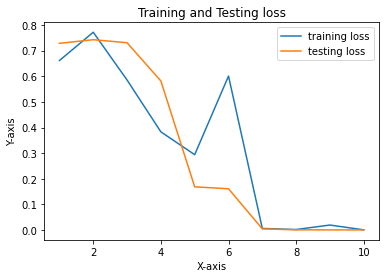

In [48]:
x_values = range(1, len(trainloss_list) + 1)
#Plotting the first line
plt.plot(x_values, trainloss_list, label='training loss')

#Plotting the second line
plt.plot(x_values, testloss_list, label='testing loss')

#Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Training and Testing loss')

#Adding legend
plt.legend()

#Displaying the plot
plt.show()

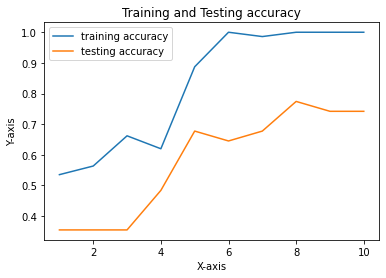

In [49]:
x_values = range(1, len(trainaccuracy_list) + 1)
#Plotting the first line
plt.plot(x_values, trainaccuracy_list, label='training accuracy')

#Plotting the second line
plt.plot(x_values, testaccuracy_list, label='testing accuracy')

#Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Training and Testing accuracy')

#Adding legend
plt.legend()

#Displaying the plot
plt.show()

# Cross Validation

In [50]:
#Defining the number of folds
num_folds = 5
kf = KFold(n_splits=num_folds)
num_epochs = 10

train_loss_fold = []
test_loss_fold = []
train_accuracy_fold = []
test_accuracy_fold = []

for fold, (train_indices, test_indices) in enumerate(kf.split(feat_newmatrix)):
    print(f'Fold {fold + 1}/{num_folds}')
    
    #Instantiating the model for this fold
    model = MyCNN()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    #Instantiating the model for this fold
    model = MyCNN()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    #Splitting data into train and test sets for this fold
    X_train_fold, X_test_fold = feat_newmatrix[train_indices], feat_newmatrix[test_indices]
    y_train_fold, y_test_fold = labels_newarr[train_indices], labels_newarr[test_indices]

    #Creating DataLoader for training
    train_dataset_fold = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold, dtype=torch.long))
    train_loader_fold = DataLoader(train_dataset_fold, batch_size=5, shuffle=True)

    #Creating DataLoader for testing
    test_dataset_fold = TensorDataset(torch.tensor(X_test_fold), torch.tensor(y_test_fold, dtype=torch.long))
    test_loader_fold = DataLoader(test_dataset_fold, batch_size=5, shuffle=False)


    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []

    for epoch in range(num_epochs):
        
        #Training loop
        model.train()
        correct_train = 0
        total_train = 0
        for matrices, label in train_loader_fold:
            optimizer.zero_grad()
            output = model(matrices)
            label = label.view(-1, 1)
            train_loss = criterion(output, label.float())
            train_loss.backward()
            optimizer.step()
            total_train += label.size(0)
            predicted_train = (torch.sigmoid(output) > 0.5).float()
            correct_train += (predicted_train == label).sum().item()
        train_loss_list.append(train_loss.item())
        train_accuracy_list.append(correct_train / total_train)

        #Testing loop
        model.eval()
        acc_test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for matrices, labels in test_loader_fold:
                outputs = model(matrices)
                labels = labels.view(-1, 1)
                test_loss = criterion(outputs, labels.float())
                acc_test_loss += test_loss.item()

                predicted_test = (torch.sigmoid(outputs) > 0.5).float()
                total_test += labels.size(0)
                correct_test += (predicted_test == labels).sum().item()
        test_loss_list.append(test_loss.item())
        test_accuracy_list.append(correct_test / total_test)
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss.item()}, Testing Loss: {test_loss.item()}')

    #Storing results for this fold
    train_loss_fold.append(train_loss_list)
    test_loss_fold.append(test_loss_list)
    train_accuracy_fold.append(train_accuracy_list)
    test_accuracy_fold.append(test_accuracy_list)


Fold 1/5
Epoch 1/10, Training Loss: 0.533202588558197, Testing Loss: 0.9057581424713135
Epoch 2/10, Training Loss: 0.3100454807281494, Testing Loss: 1.1197012662887573
Epoch 3/10, Training Loss: 0.3606733977794647, Testing Loss: 1.2354742288589478
Epoch 4/10, Training Loss: 0.7147454023361206, Testing Loss: 0.9162331223487854
Epoch 5/10, Training Loss: 0.3376476764678955, Testing Loss: 0.9045945405960083
Epoch 6/10, Training Loss: 0.01720743253827095, Testing Loss: 0.134930819272995
Epoch 7/10, Training Loss: 0.000491999730002135, Testing Loss: 0.026619361713528633
Epoch 8/10, Training Loss: -6.917455266375327e-07, Testing Loss: 2.038151979446411
Epoch 9/10, Training Loss: 4.796369103132747e-05, Testing Loss: 0.3246433436870575
Epoch 10/10, Training Loss: 0.0027088166680186987, Testing Loss: 0.10151302069425583
Fold 2/5
Epoch 1/10, Training Loss: 0.6092918515205383, Testing Loss: 0.8079289197921753
Epoch 2/10, Training Loss: 0.44571611285209656, Testing Loss: 1.1329245567321777
Epoch 3

In [51]:
for i in range(len(train_loss_fold)):
    print(f'FOR FOLD {i}:')
    print(f'train loss = {train_loss_fold[i][num_epochs-1]}')
    print(f'test loss = {test_loss_fold[i][num_epochs-1]}')
    print(f'train accuracy = {train_accuracy_fold[i][num_epochs-1]}')
    print(f'test accuracy = {test_accuracy_fold[i][num_epochs-1]}')

FOR FOLD 0:
train loss = 0.0027088166680186987
test loss = 0.10151302069425583
train accuracy = 1.0
test accuracy = 0.23809523809523808
FOR FOLD 1:
train loss = 0.00015109208470676094
test loss = 0.0035687414929270744
train accuracy = 1.0
test accuracy = 0.7142857142857143
FOR FOLD 2:
train loss = 0.00044719144352711737
test loss = 0.6621434092521667
train accuracy = 1.0
test accuracy = 0.45
FOR FOLD 3:
train loss = 0.00023661107115913182
test loss = 1.2841801643371582
train accuracy = 1.0
test accuracy = 0.4
FOR FOLD 4:
train loss = 0.0012452183291316032
test loss = 3.2357025146484375
train accuracy = 1.0
test accuracy = 0.4


In [52]:
#Creating a Testing DataLoader
test_dataset = TensorDataset(torch.tensor(feat_newmatrix), torch.tensor(labels_newarr, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

#Testing the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
loss_list = []
pred_list = []
true_list = []

# Disable gradient computation
with torch.no_grad():
    for matrices, labels in test_loader:
        outputs = model(matrices)  #Forward pass
        labels = labels.view(-1, 1)
        loss = criterion(outputs, labels.float())  #Calculate the loss
        loss_list.append(loss)
        test_loss += loss.item()  #Accumulate the loss

        predicted = (torch.sigmoid(outputs) > 0.5).float() 
        pred_list.append(predicted)
        true_list.append(labels)
        total += labels.size(0)  #Increment the total count of samples
        correct += (predicted == labels).sum().item()  #Increment the correct count

#Calculating the average test loss
avg_test_loss = test_loss / len(test_loader)

#Calculating the accuracy
accuracy = correct / total

#Calculating F1 score

true_list = [item for sublist in true_list for item in sublist.numpy()]
pred_list = [item for sublist in pred_list for item in sublist.numpy()]


f1 = f1_score(true_list, pred_list)
print(f'F1 Score: {f1}')

print(correct)
print(total)
print(f'Average Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}')

F1 Score: 0.8947368421052632
90
102
Average Test Loss: 0.5676, Accuracy: 0.8824


# Testing on new file

In [53]:
newfile = pd.read_csv('GatheredData/Fall/Areeb_back_2.csv')  # replace the string with the path to the file
newfile['source_file_id'] = 0

In [54]:
newfile = fillframes(modded_newdf.groupby('source_file_id').agg({'frame':'max'}).values.min(), 0, newfile)
newfile = fillpoints(equal_newdf.groupby(['source_file_id','frame']).agg({'DetObj#':'max'}).values.min(), 0, newfile)
newfile = newfile.sort_values(by=['frame', 'DetObj#']).reset_index(drop=True)
newfile

,frame,DetObj#,x,y,z,v,snr,noise,source_file_id
0,0,0,-0.106953,0.039876,-0.008615,0.0,305.0,473.0,0
1,0,1,0.455412,0.703981,-0.040876,0.0,278.0,446.0,0
2,0,2,-0.432412,1.729265,-0.196896,0.0,184.0,544.0,0
3,0,3,-0.115003,1.876584,-0.324012,0.0,122.0,605.0,0
4,0,4,-0.569265,2.016376,-0.119555,0.0,128.0,670.0,0
...,...,...,...,...,...,...,...,...,...
545,24,17,0.000000,0.000000,0.000000,0.0,NaN,NaN,0
546,24,18,0.000000,0.000000,0.000000,0.0,NaN,NaN,0
547,24,19,0.000000,0.000000,0.000000,0.0,NaN,NaN,0
548,24,20,0.000000,0.000000,0.000000,0.0,NaN,NaN,0


In [56]:
featsarr_new = newfile[['x','y','z','v']].values
new = featsarr_new.reshape(1, modded_newdf.groupby('source_file_id').agg({'frame':'max'}).values.min()+1, 
                           equal_newdf.groupby(['source_file_id','frame']).agg({'DetObj#':'max'}).values.min()+1, 4)
new.shape

(1, 25, 22, 4)

In [57]:
pred_data = TensorDataset(torch.tensor(new))
pred_loader = DataLoader(pred_data, batch_size=1, shuffle=False)

In [58]:
model.eval()
pred_value = model(torch.tensor(new))
if int((torch.sigmoid(pred_value) > 0.5).float()[0][0]) == 1:
    print('FALL!')
else:
    print('NOT FALL!')

FALL!
